In [1]:
import pandas as pd
import numpy as np

raw_users = pd.read_json('data/users.jsonl', lines=True)
raw_products = pd.read_json('data/products.jsonl', lines=True)
raw_sessions = pd.read_json('data/sessions.jsonl', lines=True)
raw_deliveries = pd.read_json('data/deliveries.jsonl', lines=True)

In [2]:
raw_users.dtypes

user_id     int64
name       object
city       object
street     object
dtype: object

In [3]:
raw_products.dtypes

product_id         int64
product_name      object
category_path     object
price            float64
dtype: object

In [4]:
raw_deliveries.dtypes

purchase_id             int64
purchase_timestamp     object
delivery_timestamp     object
delivery_company      float64
dtype: object

In [5]:
raw_sessions.dtypes

session_id                   int64
timestamp           datetime64[ns]
user_id                    float64
product_id                 float64
event_type                  object
offered_discount             int64
purchase_id                float64
dtype: object

### Clean user data

In [6]:
users = raw_users.astype({
    'user_id': 'float64'
})
users.set_index('user_id')
users.dtypes

user_id    float64
name        object
city        object
street      object
dtype: object

In [7]:
users.head()

,user_id,name,city,street
0,102.0,Juliusz Męcik,Warszawa,plac Krakowska 69
1,103.0,Eliza Miętka,Radom,ul. Bursztynowa 56/10
2,104.0,Kacper Kolarz,Warszawa,plac Wiślana 99
3,105.0,Tobiasz Radko,Gdynia,ulica Zwycięstwa 76/98
4,106.0,Roksana Merchel,Kutno,plac Głogowa 53/95


### Clean product data

In [8]:
products = raw_products.astype({
    'product_id': 'float64', 
    'category_path': 'unicode',
})
products.set_index('product_id')
products.dtypes
products['categories'] = products.category_path.apply(lambda s: s.split(';'))
products['main_category'] = products.categories.apply(lambda s: s[0])
products.head()

,product_id,product_name,category_path,price,categories,main_category
0,1001.0,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,"[Telefony i akcesoria, Telefony stacjonarne]",Telefony i akcesoria
1,1002.0,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50,"[Komputery, Drukarki i skanery, Biurowe urządz...",Komputery
2,1003.0,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00,"[Komputery, Drukarki i skanery, Biurowe urządz...",Komputery
3,1004.0,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,"[Gry i konsole, Gry na konsole, Gry Xbox 360]",Gry i konsole
4,1005.0,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,"[Gry i konsole, Gry na konsole, Gry Xbox 360]",Gry i konsole


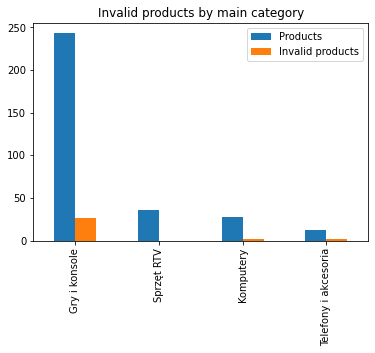

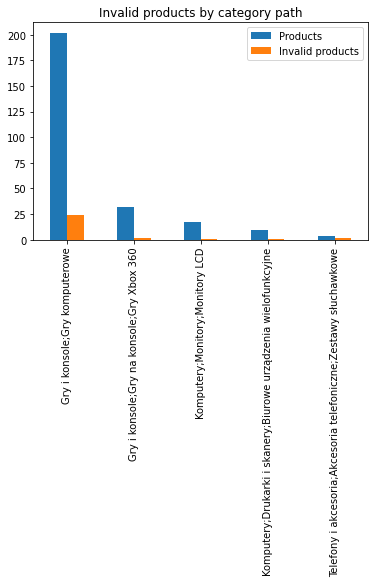

In [9]:
# analyse invalid products
invalid_prices_filter = (products['price']>0) & (products['price']<100000)

pd.concat([
    products['main_category'].value_counts().rename('Products'), 
    products[~invalid_prices_filter]['main_category'].value_counts().rename('Invalid products')
          ], axis=1).fillna(value=0).sort_values(by='Products', ascending=False).plot(kind='bar', 
        title='Invalid products by main category')

cp_df = pd.concat([
    products['category_path'].value_counts().rename('Products'), 
    products[~invalid_prices_filter]['category_path'].value_counts().rename('Invalid products')
          ], axis=1).fillna(value=0).sort_values(by='Products', ascending=False)
cp_df[cp_df['Invalid products']>0].plot(kind='bar', title='Invalid products by category path')

In [10]:
cat_df = pd.concat([
    products['category_path'].value_counts().rename('Products'), 
    products[~invalid_prices_filter]['category_path'].value_counts().rename('Invalid products')
          ], axis=1).fillna(value=0)
cat_df['invalid_percent'] = cat_df.apply(lambda r: round(100*r['Invalid products']/r['Products'],1), axis=1)
cat_df[cat_df['invalid_percent'] > 0].sort_values(by='Invalid products', ascending=False)


,Products,Invalid products,invalid_percent
Gry i konsole;Gry komputerowe,202,24.0,11.9
Gry i konsole;Gry na konsole;Gry Xbox 360,32,2.0,6.2
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,4,2.0,50.0
Komputery;Monitory;Monitory LCD,17,1.0,5.9
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,9,1.0,11.1


In [11]:
# Filter invalid prices: out of range (0.01, 100 000)
products = products[invalid_prices_filter]
print('Removed {:.1f}% of rows (before {}, after {}).'.format(
    100-100*len(products)/len(raw_products), len(products), len(raw_products)))

Removed 9.4% of rows (before 289, after 319).


In [12]:
products.head()

,product_id,product_name,category_path,price,categories,main_category
0,1001.0,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,"[Telefony i akcesoria, Telefony stacjonarne]",Telefony i akcesoria
1,1002.0,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50,"[Komputery, Drukarki i skanery, Biurowe urządz...",Komputery
2,1003.0,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00,"[Komputery, Drukarki i skanery, Biurowe urządz...",Komputery
3,1004.0,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,"[Gry i konsole, Gry na konsole, Gry Xbox 360]",Gry i konsole
4,1005.0,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,"[Gry i konsole, Gry na konsole, Gry Xbox 360]",Gry i konsole


### Clean session data

In [13]:
sessions = raw_sessions.astype({
    'session_id': 'float64'
})
sessions['made_purchase'] = sessions.purchase_id.map(lambda x: False if pd.isnull(x) else True)

sessions.dtypes

session_id                 float64
timestamp           datetime64[ns]
user_id                    float64
product_id                 float64
event_type                  object
offered_discount             int64
purchase_id                float64
made_purchase                 bool
dtype: object

#### Invalid sessions OVER CONVERSIONS

In [14]:
invalid_session_cond = sessions['product_id'].isin(products['product_id'].unique())
sessions['is_invalid'] = sessions['product_id'].isin(products['product_id'].unique())

sessions.groupby(['is_invalid', 'made_purchase']).session_id.count()

is_invalid  made_purchase
False       False             3401
            True               349
True        False            27839
            True              3184
Name: session_id, dtype: int64

#### Invalid sessions OVER USERS

count    201.000000
mean      11.202830
std        4.893347
min        0.000000
25%        9.248555
50%       10.714286
75%       12.337662
max       50.000000
Name: invalid_percent_per_user, dtype: float64

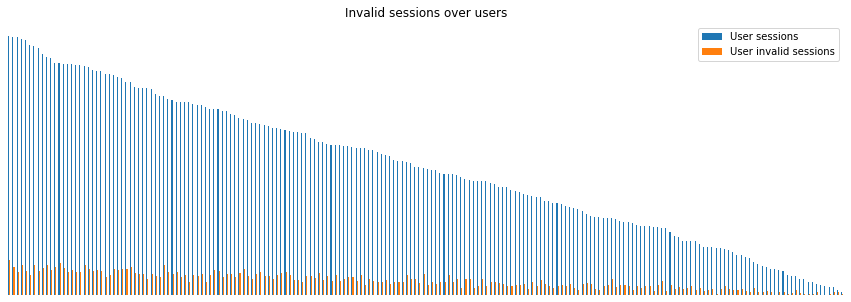

In [15]:
plt = pd.concat([
    sessions['user_id'].value_counts().rename('User sessions'), 
    sessions[~invalid_session_cond]['user_id'].value_counts().rename('User invalid sessions')
          ], axis=1).fillna(value=0).sort_values(by='User sessions', ascending=False)\
    .plot(kind='bar', title='Invalid sessions over users', figsize=(15,5), xticks=None).axis('off')


df = pd.concat([
    sessions['user_id'].value_counts(dropna=False).rename('User sessions'), 
    sessions[~invalid_session_cond]['user_id'].value_counts(dropna=False).rename('User invalid sessions')
          ], axis=1).fillna(value=0).sort_values(by='User sessions', ascending=False)
df['invalid_percent_per_user'] = df.apply(lambda r: 100*r['User invalid sessions']/r['User sessions'], axis=1)
df['invalid_percent_per_user'].describe()

#### Invalid sessions OVER TIME

(-0.5, 88.5, 0.0, 574.35)

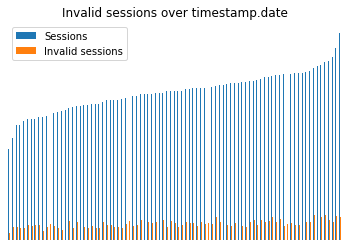

In [16]:
sessions['timestamp_date'] = sessions['timestamp'].dt.date

pd.concat([
    sessions['timestamp_date'].value_counts().rename('Sessions'), 
    sessions[~invalid_session_cond]['timestamp_date'].value_counts().rename('Invalid sessions')
          ], axis=1).fillna(value=0).sort_values(by='Sessions', ascending=True)\
    .plot(kind='bar', title='Invalid sessions over timestamp.date').axis('off')


#### Filtering sessions

In [17]:
sessions = sessions[invalid_session_cond]
print('Removed {:.1f}% of rows (before {}, after {}).'.format(
    100-100*len(sessions)/len(raw_sessions), len(sessions), len(raw_sessions)))


sessions.head()

Removed 10.8% of rows (before 31023, after 34773).


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,made_purchase,is_invalid,timestamp_date
0,100001.0,2020-01-17 16:08:57,102.0,1001.0,VIEW_PRODUCT,0,NaN,False,True,2020-01-17
1,100002.0,2020-01-07 05:10:41,102.0,1277.0,VIEW_PRODUCT,20,NaN,False,True,2020-01-07
2,100002.0,2020-01-07 05:14:26,102.0,1276.0,VIEW_PRODUCT,20,NaN,False,True,2020-01-07
3,100003.0,2020-01-16 09:37:42,102.0,1276.0,VIEW_PRODUCT,0,NaN,False,True,2020-01-16
4,100003.0,2020-01-16 09:38:22,102.0,1277.0,VIEW_PRODUCT,0,NaN,False,True,2020-01-16


### Clean delivery data

In [18]:
deliveries = raw_deliveries.astype({
    'purchase_id': 'float64', 
    'delivery_timestamp': 'datetime64',
    'purchase_timestamp': 'datetime64'
})
deliveries.set_index('purchase_id')

deliveries.dtypes

purchase_id                  float64
purchase_timestamp    datetime64[ns]
delivery_timestamp    datetime64[ns]
delivery_company             float64
dtype: object

In [19]:
deliveries['delivery_time'] = deliveries.apply(lambda row: row['delivery_timestamp'] - row['purchase_timestamp'], axis=1)
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,delivery_time
0,20001.0,2020-01-13 00:29:10,2020-01-17 00:31:53,516.0,4 days 00:02:43
1,20002.0,2020-02-04 19:09:12,2020-02-06 19:13:06,516.0,2 days 00:03:54
2,20003.0,2020-01-16 14:40:39,2020-01-18 14:41:27,620.0,2 days 00:00:48
3,20004.0,2020-02-05 08:08:59,NaT,360.0,NaT
4,20005.0,2020-02-18 09:27:06,2020-02-21 09:31:35,620.0,3 days 00:04:29


In [20]:
deliveries = deliveries[deliveries.purchase_id.isin(sessions['purchase_id'])]
print('Removed {:.1f}% of rows (before {}, after {}).'.format(
    100-100*len(deliveries)/len(raw_deliveries), len(deliveries), len(raw_deliveries)))


Removed 9.9% of rows (before 3184, after 3533).


## Merge datasets

In [21]:
data = sessions.merge(products, how='left', on='product_id')
data = data.merge(users, how='left', on='user_id')
data = data.merge(deliveries, how='left', on='purchase_id')
data = data.drop(['category_path'], axis=1)
data.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,made_purchase,is_invalid,timestamp_date,...,price,categories,main_category,name,city,street,purchase_timestamp,delivery_timestamp,delivery_company,delivery_time
0,100001.0,2020-01-17 16:08:57,102.0,1001.0,VIEW_PRODUCT,0,NaN,False,True,2020-01-17,...,58.97,"[Telefony i akcesoria, Telefony stacjonarne]",Telefony i akcesoria,Juliusz Męcik,Warszawa,plac Krakowska 69,NaT,NaT,NaN,NaT
1,100002.0,2020-01-07 05:10:41,102.0,1277.0,VIEW_PRODUCT,20,NaN,False,True,2020-01-07,...,2317.02,"[Komputery, Tablety i akcesoria, Tablety]",Komputery,Juliusz Męcik,Warszawa,plac Krakowska 69,NaT,NaT,NaN,NaT
2,100002.0,2020-01-07 05:14:26,102.0,1276.0,VIEW_PRODUCT,20,NaN,False,True,2020-01-07,...,1816.97,"[Komputery, Tablety i akcesoria, Tablety]",Komputery,Juliusz Męcik,Warszawa,plac Krakowska 69,NaT,NaT,NaN,NaT
3,100003.0,2020-01-16 09:37:42,102.0,1276.0,VIEW_PRODUCT,0,NaN,False,True,2020-01-16,...,1816.97,"[Komputery, Tablety i akcesoria, Tablety]",Komputery,Juliusz Męcik,Warszawa,plac Krakowska 69,NaT,NaT,NaN,NaT
4,100003.0,2020-01-16 09:38:22,102.0,1277.0,VIEW_PRODUCT,0,NaN,False,True,2020-01-16,...,2317.02,"[Komputery, Tablety i akcesoria, Tablety]",Komputery,Juliusz Męcik,Warszawa,plac Krakowska 69,NaT,NaT,NaN,NaT


In [22]:
data.to_json('data/merged.jsonl', orient='records', lines=True)